In [12]:
# !pip install xarray prophet gluonts mxnet h5py mxnet-mkl==1.6.0 numpy==1.23.1

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from prophet import Prophet
from matplotlib.dates import date2num

from gluonts.mx.model.renewal import DeepRenewalProcessEstimator
from gluonts.mx.distribution import ZeroInflatedNegativeBinomialOutput, StudentTOutput #likelihood
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
from gluonts.mx.trainer import Trainer
from gluonts.mx.trainer.model_averaging import ModelAveraging, SelectNBestSoftmax, SelectNBestMean

from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
import random

latitudes = np.flipud(np.arange(65) * 0.25 + 5)
longitudes = np.arange(37) * 0.25 + 97

In [6]:
ds = xr.open_dataset("data/temp2m.nc")
df = ds.to_dataframe()
df.reset_index(inplace=True)
df['date'] = df['date'].dt.date
df['lat'] = [latitudes[i] for i in df['lat']]
df['lon'] = [longitudes[i] for i in df['lon']]
df['lat_lon'] = df['lat'].astype(str) + ', ' + df['lon'].astype(str)
df = df.groupby(['date', 'lat_lon'])['temp2m'].max().reset_index()
pivoted_df = df.pivot(index=['date'], columns='lat_lon', values='temp2m').reset_index()
pivoted_df = pivoted_df.set_index('date')
pivoted_df

lat_lon,"10.0, 100.0","10.0, 100.25","10.0, 100.5","10.0, 100.75","10.0, 101.0","10.0, 101.25","10.0, 101.5","10.0, 101.75","10.0, 102.0","10.0, 102.25",...,"9.75, 97.5","9.75, 97.75","9.75, 98.0","9.75, 98.25","9.75, 98.5","9.75, 98.75","9.75, 99.0","9.75, 99.25","9.75, 99.5","9.75, 99.75"
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,28.162183,28.162183,28.262183,28.362183,28.462183,28.462183,28.562183,28.562183,28.662183,28.662183,...,27.962183,27.962183,28.062183,27.962183,31.562183,31.662183,31.162183,27.862183,27.962183,27.962183
2020-01-02,28.121875,28.121875,28.221875,28.221875,28.221875,28.321875,28.521875,29.021875,29.121875,29.121875,...,27.721875,27.821875,27.821875,28.021875,31.521875,31.721875,31.021875,27.821875,27.821875,27.913818
2020-01-03,28.470313,28.670313,28.770313,28.770313,28.770313,28.770313,28.770313,28.770313,28.670313,28.670313,...,27.895728,27.795728,27.870313,28.170313,31.670313,31.370313,30.870313,28.070313,27.970313,27.970313
2020-01-04,28.396338,28.396338,28.448950,28.496338,28.496338,28.596338,28.596338,28.596338,28.548950,28.596338,...,28.048950,28.096338,28.096338,28.196338,31.996338,32.396338,31.596338,28.148950,28.196338,28.248950
2020-01-05,28.538770,28.638770,28.638770,28.638770,28.638770,28.638770,28.738770,28.938770,28.938770,28.938770,...,28.050024,27.950024,28.038770,28.138770,32.338770,32.138770,31.438770,28.238770,28.338770,28.338770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-17,28.529922,28.759922,28.909922,28.949922,28.939922,28.919922,28.829922,28.679922,28.569922,28.569922,...,28.467754,28.303398,28.143398,28.013398,27.809922,25.489922,26.829922,27.869922,27.859922,27.959922
2023-11-18,27.884727,27.914727,28.007402,28.297402,28.707402,28.877402,28.767402,28.537402,28.207402,28.101074,...,28.131074,28.031074,27.801074,27.474727,26.744727,24.024727,25.644727,27.538940,27.764727,27.804727
2023-11-19,27.587480,27.646133,28.076133,27.996133,27.986133,27.977480,28.001367,27.976133,27.877480,27.957480,...,27.746133,27.976133,28.376133,28.826133,29.356133,27.426133,27.586133,28.016133,27.926133,27.936133


In [7]:
training_list = []
for data in pivoted_df:
    training_list.append({"start": pivoted_df.index[0], "target": pivoted_df[data][:datetime.date(2023, 1, 1)].tolist()})

In [8]:
training_data = ListDataset(
    training_list,
    freq="D"
)

In [9]:
entry = next(iter(training_data))
train_series = to_pandas(entry)

In [10]:
test_list = []
for data in pivoted_df:
    test_list.append({"start": pivoted_df.index[0], "target": pivoted_df[data][:datetime.date(2023, 11, 19)].tolist()})

In [11]:
test_data = ListDataset(
    test_list,
    freq="D"
)

In [12]:
entry = next(iter(test_data))
test_series = to_pandas(entry)

In [13]:
index_train_end = pivoted_df.index.get_loc(datetime.date(2023, 1, 1))

In [14]:
index_train_end

1096

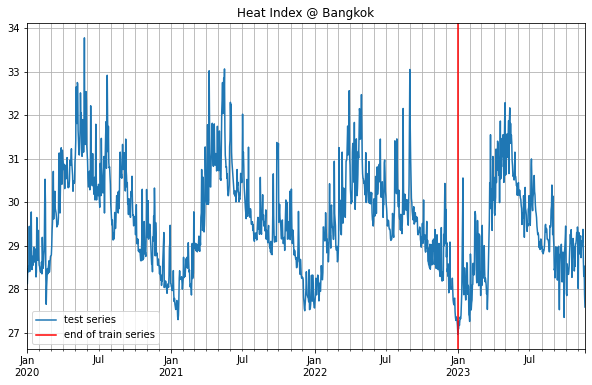

In [15]:
plt.figure(figsize=(10, 6))
test_series.plot(title='Heat Index @ Bangkok')

plt.axvline(pivoted_df.index[index_train_end], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="lower left")
plt.show()

## Select the Model

In [12]:
callbacks = [
    LearningRateReduction(objective="min",
                          patience=10,
                          base_lr=1e-3,
                          decay_factor=0.5,
                          ),
    ModelAveraging(avg_strategy=SelectNBestMean(num_models=2))
]


estimator = DeepRenewalProcessEstimator(
#     freq="1D",
    prediction_length=306,
    context_length=306,
    num_layers = 10,
    num_cells = 500,
#     distr_output=StudentTOutput(),
    dropout_rate=0.01,
    trainer=Trainer(#ctx = mx.context.gpu(),
                    epochs=10,
                    callbacks=callbacks))


# estimator = DeepAREstimator(
#     freq="M",
#     prediction_length=306,
#     context_length=306,
#     num_layers = 2,
#     num_cells = 50,
#     distr_output=StudentTOutput(),
#     dropout_rate=0.01,
#     trainer=Trainer(#ctx = mx.context.gpu(),
#                     epochs=1,
#                     callbacks=callbacks))


In [13]:
predictor = estimator.train(training_data)

100%|██████████| 50/50 [27:27<00:00, 32.96s/it, epoch=10/10, avg_epoch_loss=3.95]


In [14]:

# save the trained model in tmp/
from pathlib import Path
predictor.serialize(Path("model/gluonts_deep_renewal_processes_temp2m/"))


In [4]:

# loads it back
from gluonts.model.predictor import Predictor
from pathlib import Path
predictor_deserialized = Predictor.deserialize(Path("model/gluonts_deep_renewal_processes_temp2m/"))

In [44]:
# forecast_it, ts_it = make_evaluation_predictions(
#     dataset=test_data,  # test dataset
#     predictor=predictor,  # predictor
#     num_samples=100,  # number of sample paths we want for evaluation
# )

In [16]:
test_data2 = ListDataset(
    random.sample(test_list, 1),
    freq="D"
)

In [18]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data2,  # test dataset
    predictor=predictor_deserialized,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [19]:
forecasts = list(forecast_it)
tss = list(ts_it)
ts_entry = tss[0]
forecast_entry = forecasts[0]

In [23]:
forecast_entry

gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[ 44.,   3.,  13., ..., 104.,   1.,  29.],
       [ 11.,  45.,  29., ...,   4.,  10.,   1.],
       [127., 121., 133., ...,   7.,   7.,   1.],
       ...,
       [  8.,  39.,   2., ...,  44.,  36.,  12.],
       [ 33.,  39.,   2., ...,  27.,  11., 151.],
       [ 13.,  29.,   6., ...,  12.,  10.,  25.]], dtype=float32), start_date=Period('2023-01-18', 'D'))

In [21]:
index = 1
ts_entry = tss[index]
forecast_entry = forecasts[index]

plt.figure(figsize=(10, 6))
plt.plot(tss[index].to_timestamp(),label="test series")

# Assuming forecasts[index] is a gluonts.model.forecast.Forecast object
forecast_index = np.array(forecast_entry.index.to_timestamp())
forecast_values = np.array(forecast_entry.quantile(0.5))  # Convert to numpy array

plt.plot(forecast_index, forecast_values, label="median forecast", color='g')
for interval in (0.5, 0.9):
    label = interval
    low = (1 - interval) / 2
    plt.fill_between(
        forecast_entry.index.to_timestamp(),
        forecast_entry.quantile(low),
        forecast_entry.quantile(1 - low),
        alpha=0.5 - interval / 3,
        facecolor='g',
        label=None,
    )


plt.grid(which="both")
plt.axvline(pivoted_df.index[index_train_end], color='r', label="end of train series") # end of train dataset
plt.legend(loc="lower left")
plt.title('Surface Temperature @ Nakhon Ratchasima')




plt.show()

IndexError: list index out of range

In [ ]:
for index in range(10):
    print(index)